# Sentiment Analysis with NLTK and VADER
In this project, we will use [NLTK](https://pypi.org/project/nltk/) and [VADER](https://github.com/cjhutto/vaderSentiment)
to analyze the sentiment of the provided text.

## Step 1: Load the input text
To begin, we install dependencies and load the input text from `input.txt`:

In [16]:
!pip install --disable-pip-version-check -r requirements.txt

from pathlib import Path

# read and close the file in one line
# see https://stackoverflow.com/a/49564464
text_file = Path("input.txt").read_text()

# ensure that we've read the correct file
print("\nRead input file: {}...".format(text_file[0:30]))


Read input file: "Stop blushing. I'm not needli...


## Step 2: Split into two paragraphs and reformat text
The input text file seems to contain two paragraphs that could be analyzed separately.
These paragraphs are seperated from each other by double newlines, so we split them here.
The input text file also contains newlines to avoid any one line from being too long, so
we then remove all the newlines.

In [2]:
# split into paragraphs and remove newlines inside paragraphs
# we also need to remove double-spaces because some lines end with a space
paragraphs = text_file.split("\n\n")
paragraphs = [paragraph.replace("\n", " ").replace("  ", " ") for paragraph in paragraphs]
print("Extracted {} paragraphs: '{}...' '{}...'".format(len(paragraphs), paragraphs[0][0:20], paragraphs[1][0:20]))

Extracted 2 paragraphs: '"Stop blushing. I'm ...' 'I think you may like...'


## Step 3: Calculating overall sentiment with NLTK and VADER
To begin, we calculate the overall sentiment of our input text with VADER, a sentiment
analysis tool built from the research of Hutto, C.J. & Gilbert.

### Step 3.1: Download & install
First, we must download the `vader_lexicon` NLTK resource.

In [3]:
import nltk
nltk.download('vader_lexicon')

[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Step 3.2: Run analysis on input text
We rejoin the paragraphs and run the analysis:

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

paragraphs_together = "\n".join(paragraphs)
together_scores = analyzer.polarity_scores(paragraphs_together)

print("Got scores from paragraphs together {} ".format(together_scores))

Got scores from paragraphs together {'neg': 0.065, 'neu': 0.748, 'pos': 0.187, 'compound': 0.9982} 


### Step 3.3: Extract a single sentiment score
We will now extract a single sentiment score from the text. This value is in the range
`[-1, 1]`, with higher values signaling a more positive sentiment and lower values signaling
a more negative sentiment. The meaning of this score will be explained more in the conclusion.

In [5]:
single_sentiment_score = together_scores.get("compound")
print("Got single sentiment score: {}".format(single_sentiment_score))

Got single sentiment score: 0.9982


### Step 3.4: Run analysis on individual paragraphs
We now run the VADER analysis on each paragraph individually:

In [6]:
paragraphs_scores = [analyzer.polarity_scores(paragraph) for paragraph in paragraphs]

print("Got scores from individual paragraphs {} ".format(paragraphs_scores))

Got scores from individual paragraphs [{'neg': 0.124, 'neu': 0.731, 'pos': 0.145, 'compound': 0.521}, {'neg': 0.05, 'neu': 0.721, 'pos': 0.23, 'compound': 0.9981}] 


### Step 3.5: Visualize results
We leverage [Matplotlib](https://pypi.org/project/matplotlib/) to visualize our results in a stacked-bar chart.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.ioff()

# we need to add 1 to the start and stop because otherwise our paragraphs would be 0-indexed
paras_list = list(range(1, len(paragraphs) + 1))

# create labels for each paragraph
paras_labels = ["Paragraph {}".format(para_num) for para_num in paras_list]
labels = ["Whole Text"] + paras_labels
print(labels)

# extract the scores from the paragraphs together and individually
positive_scores = [together_scores.get("pos")] + [score.get("pos") for score in paragraphs_scores]
neutral_scores = [together_scores.get("neu")] + [score.get("neu") for score in paragraphs_scores]
negative_scores = [together_scores.get("neg")] + [score.get("neg") for score in paragraphs_scores]

print(positive_scores, neutral_scores, negative_scores)

width = 0.35

['Whole Text', 'Paragraph 1', 'Paragraph 2']
[0.187, 0.145, 0.23] [0.748, 0.731, 0.721] [0.065, 0.124, 0.05]


In [8]:
# create the first subplot: the single score
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.barh("Score", single_sentiment_score, color="#aa3300")
# the score is [-1, 1] so make the chart reflect that
ax.set_xbound(-1, 1)
fig.set_figheight(.75)
ax.set_title("Single sentiment score")

Text(0.5, 1.0, 'Single sentiment score')

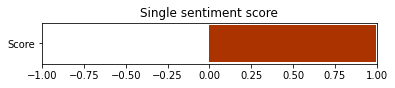

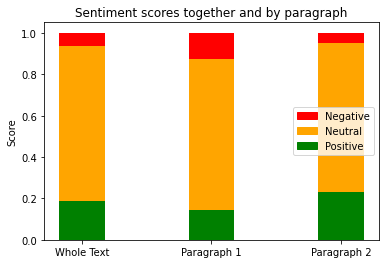

In [9]:
# create the second subplot: the score breakdowns
fig2, ax2 = plt.subplots()
fig2.patch.set_facecolor('white')
ax2.bar(labels, positive_scores, width, label="Positive", color="green")
ax2.bar(labels, neutral_scores, width, label="Neutral", bottom=positive_scores, color="orange")

# matplotlib expects that we sum the previous values to correctly stack our bar charts
pos_neu_scores_sum = [sum(x) for x in zip(positive_scores, neutral_scores)]
ax2.bar(labels, negative_scores, width, label='Negative', bottom=pos_neu_scores_sum, color="red")

ax2.set_ylabel("Score")
ax2.set_title("Sentiment scores together and by paragraph")

# workaround: see https://matplotlib.org/2.0.2/users/legend_guide.html
patches = [mpatches.Patch(color="red", label="Negative"), mpatches.Patch(color="orange", label="Neutral"), mpatches.Patch(color="green", label="Positive")]
ax2.legend(handles=patches)

plt.show()

### Step 3.5: Unhappy conclusions
The "single sentiment" score from above seems suspiciously high: a value very near 1
for a variable in the range of `[-1, 1]` should signal an extremely positive sentiment,
yet this does not seem like an accurate reflection of the text. A likely reason for this
is the fact that the VADER sentiment analysis is designed for shorter amounts of text.

Next, we will try a different approach:

## Step 4: Sentence-by-sentence analysis
Perhaps a way to overcome the limitations of VADER is to analyze on a per-sentence basis and then
aggregate per-sentence scores to a total score.

### Step 4.1: Splitting our corpus into individual sentences
Fortunately for us, NLTK includes a `sent_tokenize()` method that allows us to split
the text into individual sentences. This method uses the Punkt sentence tokenizer, which
is smart enough to split on grammatical sentence boundaries and not just on punctuation.

Here is an excerpted example from the [NLTK source code](https://www.nltk.org/_modules/nltk/tokenize/punkt.html):
```
>>> import nltk.data
>>> text = '''
... Punkt knows that the periods in Mr. Smith and Johann S. Bach
... do not mark sentence boundaries.  And sometimes sentences
... can start with non-capitalized words.  i is a good variable
... name.
... '''
>>> sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
>>> print('\n-----\n'.join(sent_detector.tokenize(text.strip())))
Punkt knows that the periods in Mr. Smith and Johann S. Bach
do not mark sentence boundaries.
-----
And sometimes sentences
can start with non-capitalized words.
-----
i is a good variable
name.
```
Now, we will use the `sent_tokenize()` method to tokenize our individual paragraphs.
We will start by downloading the Punkt sentence tokenizer.

In [10]:
nltk.download('punkt')

paragraphs_sentences = [nltk.sent_tokenize(paragraph) for paragraph in paragraphs]
print("Tokenized paragraphs into sentences: {} {}".format(paragraphs_sentences[0][0:2], paragraphs_sentences[1][0:2]))

Tokenized paragraphs into sentences: ['"Stop blushing.', "I'm not needling, really I'm not."] ['I think you may like to know something of his person and character.', 'He had an excellent constitution of body, was of middle stature, but well set, and very strong; he was ingenious, could draw prettily, was skilled a little in music, and had a clear, pleasing voice, so that when he played psalm tunes on his violin and sung withal, as he sometimes did in an evening after the business of the day was over, it was extremely agreeable to hear.']


[nltk_data]   Package punkt is already up-to-date!


## Step 4.2: Running VADER analysis on each sentence
Now we go through each sentence of each paragraph and run VADER analysis on it.

In [11]:
paragraphs_sentences_scores = [[analyzer.polarity_scores(sentence) for sentence in sentences] for sentences in paragraphs_sentences]
print("Scored sentences in paragraphs: {} {}".format(paragraphs_sentences_scores[0][0:2], paragraphs_sentences_scores[1][0:2]))

Scored sentences in paragraphs: [{'neg': 0.688, 'neu': 0.312, 'pos': 0.0, 'compound': -0.296}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}] [{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'compound': 0.3612}, {'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.9779}]


## Step 4.3: Average compound scores
Now we sum each sentence's compound scores and divide by the total number of sentences
to determine an average compound score.

In [12]:
# over each paragraph,
paragraphs_average_compound = [
    # sum the compound scores...
    sum([sentence.get("compound") for sentence in paragraph])
    # then divide by the amount of sentences to get the average
    / len(paragraph)
    for paragraph in paragraphs_sentences_scores
]

print("Average compound score for each paragraph: {}".format(paragraphs_average_compound))

Average compound score for each paragraph: [0.0014400000000000036, 0.7775857142857143]


## Step 4.4: Average scores across paragraphs
We now combine the scores from both paragraphs into a single score, range `[-1, 1]`:

In [13]:
single_compound_sentence_score = sum(paragraphs_average_compound) / len(paragraphs_average_compound)
print("Single compound score: {:.4f}".format(single_compound_sentence_score))

Single compound score: 0.3895


## Step 4.5: Visualize results
First we plot our averaged scores. Note that the paragraph 1 score is very low, so it does not appear on the graph.

In [14]:
# create the first subplot: the single score & paragraph individuals
fig3, ax3 = plt.subplots()
fig3.patch.set_facecolor('white')
ax3.barh("Paragraph 2", paragraphs_average_compound[1])
ax3.barh("Paragraph 1", paragraphs_average_compound[0])
ax3.barh("Overall Score", single_compound_sentence_score)
# the score is [-1, 1] so make the chart reflect that
ax3.set_xbound(-1, 1)
fig3.set_figheight(.75)
ax3.set_title("Single compound sentence sentiment score")

Text(0.5, 1.0, 'Single compound sentence sentiment score')

Then we plot the individual sentences that contributed to the compound score:

In [15]:
# loop through each paragraph
for i in range(0, len(paragraphs_sentences_scores)):
    fig4, ax4 = plt.subplots()
    fig4.patch.set_facecolor('white')
    para_len = len(paragraphs_sentences_scores[i])

    # reverse so sentence 0 is first
    plt.gca().invert_yaxis()

    added = 0

    # add a bar for each sentence
    for j in range(0, para_len):
        compound = paragraphs_sentences_scores[i][j].get("compound")
        if abs(compound) > 0: # only include non-zero sentences
            added += 1
            ax4.barh("Sentence {}".format(j + 1), compound)

    # the score is [-1, 1] so make the chart reflect that
    ax4.set_xbound(-1, 1)
    fig4.set_figheight(added * .3)
    ax4.set_title("Scores for most important paragraph {} sentences".format(i + 1))

## Step 5: Conclusions
*Note: the conclusions here are the same as in [README.md](README.md).*

### Sentiment score of [input.txt](input.txt)
`single_compound_sentence_score`: 0.3895

This value calculated by my code is in the range `[-1, 1]`, with values closer to 1 being
more positive and values closer to -1 being more negative. This suggests a slightly positive
sentiment, which agrees with what I would expect given my reading of the input text. More specifically,
the second paragraph was calculated to have a moderately high sentiment score, but the first paragraph had
a sentiment score of almost zero. This closely matches with my expectations, as I perceived the first
paragraph to have a neutral sentiment and the second paragraph to have a strongly positive
sentiment for an overall positive sentiment.

### Individual paragraph and sentence scores
This figure visualizes the determined sentiment score for the whole text, first paragraph, and second paragraph. Note
that the sentiment score for the first paragraph was very close to zero, and thus no bar shows
for that paragraph.

![Figure 3](./figures/fig3.png)

The sentiment of the most important sentences in the first and second paragraphs is shown in the
following figures.

![Figure 4](./figures/fig4.png)
![Figure 5](./figures/fig5.png)